### Importing Libraries

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("RSCCASN.csv")

In [3]:
data.head()

,DATE,RSCCASN
0,1992-01-01,6938
1,1992-02-01,7524
2,1992-03-01,8475
3,1992-04-01,9401
4,1992-05-01,9558


In [4]:
### Making Date column as index

In [5]:
data.set_index("DATE" , inplace = True)

In [6]:
data.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


### Dividing Data into Train And Test

In [7]:
len(data)

334

In [8]:
test_size = 18

In [9]:
test_index = len(data) - test_size

In [10]:
test_index

316

In [14]:
train = data.iloc[ : test_index ]

test = data.iloc[ test_index : ]

In [17]:
#test

### Scaling The Data

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
scaler = MinMaxScaler()

In [20]:
scaled_train = scaler.fit_transform(train)

scaled_test = scaler.transform(test)

### Creating Time Series Generator

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
length = 12 #giving 12 inputs to predict 1 output

generator = TimeseriesGenerator(scaled_train , scaled_train , length = length , batch_size= 1)

In [23]:
X , y = generator[0]

### Creating Model

In [30]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, LSTM

In [31]:
n_features = 1

In [32]:
model = Sequential()

In [33]:
model.add(LSTM(100 , activation= "relu" , input_shape = (length , n_features)))

model.add(Dense(1))

model.compile(optimizer = "adam" , loss = "mse")

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### Creating Early Stopping

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

In [36]:
early_stop = EarlyStopping(monitor = "val_loss" , patience = 2)

### Creating Validation Generator

In [37]:
validation_generator = TimeseriesGenerator(scaled_test , scaled_test , length = length , batch_size=1)

### Fitting The Generator

In [38]:
model.fit_generator(generator , epochs = 20 , validation_data= validation_generator, callbacks=[early_stop])

Epoch 1/20


C:\Users\Sony\AppData\Local\Temp\ipykernel_14548\2547069253.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator , epochs = 20 , validation_data= validation_generator, callbacks=[early_stop])


304/304 [==============================] - 5s 9ms/step - loss: 0.0246 - val_loss: 0.0064
Epoch 2/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0182 - val_loss: 0.0042
Epoch 3/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0101 - val_loss: 0.0053
Epoch 4/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0040 - val_loss: 9.6414e-04
Epoch 5/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0018 - val_loss: 2.0561e-04
Epoch 6/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 7/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0022 - val_loss: 0.0019


In [39]:
losses = pd.DataFrame(model.history.history)

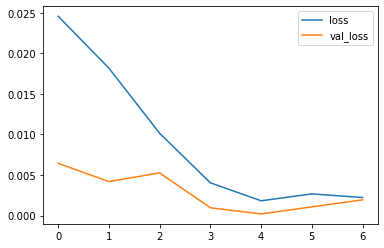

In [41]:
losses.plot();

### Getting and Storing The Predictions

In [57]:
first_eval_batch = scaled_train[-length:]

first_eval_batch = first_eval_batch.reshape((1, length, n_features))

In [58]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 28ms/step


array([[0.48085755]], dtype=float32)

In [59]:
scaled_test[0]

array([0.61087714])

In [60]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 26ms/step


### Inverse Transforming Predictions

In [61]:
true_predictions = scaler.inverse_transform(test_predictions)

### Adding true_prediction to test data

In [62]:
test["predictions"] = true_predictions

C:\Users\Sony\AppData\Local\Temp\ipykernel_14548\1078118355.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions"] = true_predictions


In [64]:
test.head()

,RSCCASN,predictions
DATE,,
2018-05-01,23764,20182.740387
2018-06-01,21589,19280.488581
2018-07-01,21919,19485.510363
2018-08-01,23381,20980.179569
2018-09-01,20260,18964.359703


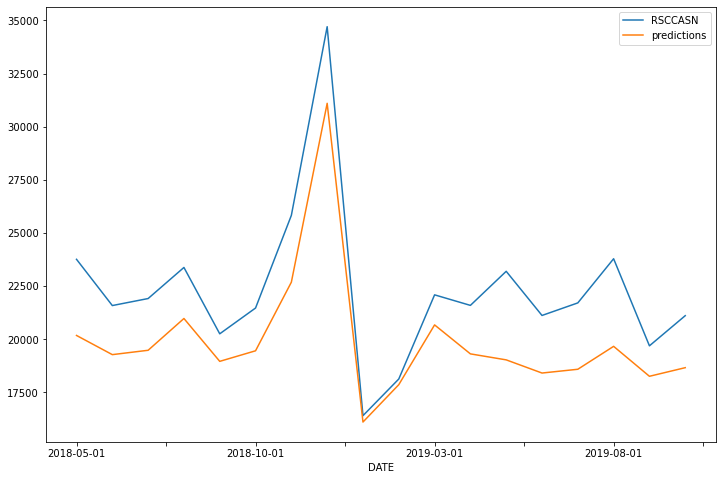

In [66]:
test.plot(figsize = (12,8));

### Forecasting Into Future

In [67]:
full_scaler = MinMaxScaler()

In [68]:
scaled_full_df = full_scaler.fit_transform(data)

In [69]:
length = 12

In [70]:
generator = TimeseriesGenerator(scaled_full_df , scaled_full_df , length = length , batch_size=1)

In [71]:
model = Sequential()

In [72]:
model.add(LSTM(100 , activation="relu" , input_shape = (length , n_features)))

model.add(Dense(1))

model.compile(optimizer = "adam" , loss = "mse")

In [73]:
model.fit_generator(generator , epochs = 8)

Epoch 1/8


C:\Users\Sony\AppData\Local\Temp\ipykernel_14548\2304884248.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator , epochs = 8)


322/322 [==============================] - 4s 7ms/step - loss: 0.0241
Epoch 2/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0181
Epoch 3/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0127
Epoch 4/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0065
Epoch 5/8
322/322 [==============================] - 3s 10ms/step - loss: 0.0030
Epoch 6/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0019
Epoch 7/8
322/322 [==============================] - 3s 9ms/step - loss: 0.0016
Epoch 8/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0017


In [75]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_df[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 44ms/step


### Inversing the scale

In [76]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index 

In [77]:
data.tail()

,RSCCASN
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [78]:
forecast_index = pd.date_range(start = "2019-11-01",
                              periods = periods,
                              freq="MS")

In [79]:
forecast_df = pd.DataFrame(data = forecast , index = forecast_index , columns=["FORECASTS"])

In [88]:
data.tail()

,RSCCASN
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [81]:
forecast_df.head()

,FORECASTS
2019-11-01,24816.308179
2019-12-01,33890.815555
2020-01-01,16490.104861
2020-02-01,17820.531722
2020-03-01,21079.718892


### Plotting Forecast_df along with original data

In [102]:
final = pd.concat((data , forecast_df))

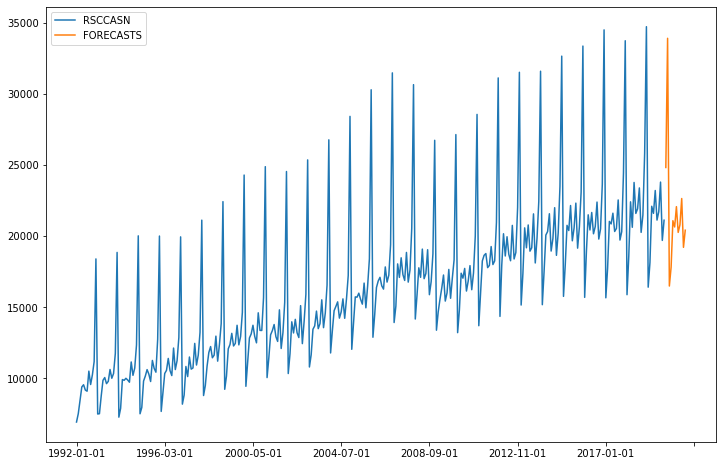

In [108]:
final.plot(figsize=(12,8));
